# Look up protein expression of TF in celltypes.
## 04-02-25
### 04-05-25 Tried chatgpt 1o Pro.  Amazing.  it call the easy ones (75%) and directed me to resolve the split ones that were unclear.
### 04-11-24  Cleaned up the plot labels 
### 05-01-25 Removed thymus and zero counts in charts.  Remade charts for figure. Reroganized so histograms followed heatmaps for Protein.
### 05-02-25 added fraction based histograms 
### 05-05-25 updated charts to make .pdf's for a supplemental figure

### 06-17-25 fixed error in number of TF's in both. now = 918.
### 06-25-25 fixed cell type mapping for alveolar and pneumocytes

### 06-25-25 use new file from Protein Atlas that includes subcellular location
### 06-25-25 the number of TF's in both is now 699 because 'uncertain' antibody stainings were eliminated.
### 06-27-25 new version from Konstantin with many more TF's

### 07-01-25 added Madhav style charts

## 08-05025 added comparison at end to TF generated in tissue

## 08-20-25. Removed unchar for GITHUB push



In [100]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import matplotlib.patches as mpatches
import seaborn as sns
import random


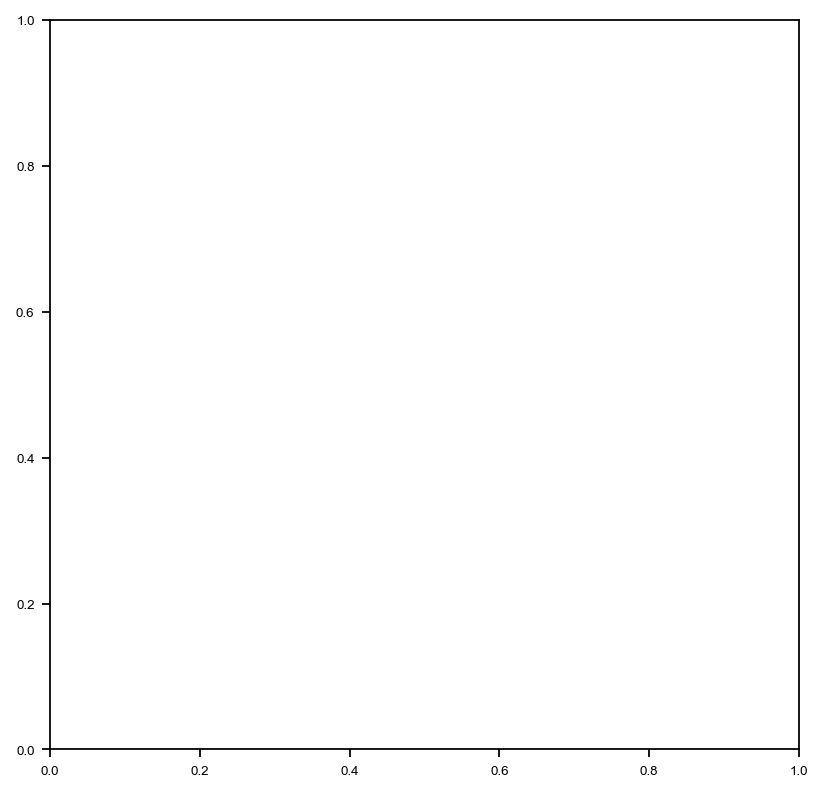

In [101]:
sc.settings.set_figure_params(dpi=80, dpi_save= 300, fontsize=6, 
                              facecolor='white', frameon=True, 
                              figsize=(3.0, 2.0), vector_friendly = False, 
                              transparent=True, format="pdf")

sns.set_style("ticks", rc = {'text.color' : "black",
                             'linecolor' : "black",
                             'axes.edgecolor' : "black",
                            'axes.labelcolor' : "black",
                            "xtick.color" : "black",
                            "ytick.color" : "black"})
fig, ax = plt.subplots(figsize = (6.0,6.0))

In [102]:
DATA_IN_DIR = '/hpc/mydata/robert.jones/TFManuscript2GITHubPush/'

## read tau and mean expression data from T. Sapiens

In [103]:
# mean meta data so we can look at cell types and tissues
cellfile = DATA_IN_DIR + 'Results/TFonly/TSP1_30_by_CellType_Full_Version2d_Nov2024_LogNorm_10XOnly_Mean_TFonly.csv'
broadfile = DATA_IN_DIR + 'Results/TFonly/TSP1_30_by_BroadCellClass_Full_Version2d_Nov2024_LogNorm_10XOnly_Mean_TFonly.csv'
tissfile = DATA_IN_DIR + 'Results/TFonly/TSP1_30_by_Tissue_Full_Version2d_Nov2024_LogNorm_10XOnly_Mean_TFonly.csv'


#meanexpBroadCT = pd.read_csv(broadfile, index_col = 0)
#meanexpBroadCT = pd.read_csv(broadfile, index_col = 0)

In [104]:
# gen mean rna expression data
meanexpCT = pd.read_csv(cellfile, index_col = 0)
print(len(meanexpCT.columns))
print(len(meanexpCT.index))

# get tau's from cell type taus for ranking 
TFtaus =  pd.read_csv('/hpc/mydata/robert.jones/TFanalysisReviewCycle/TauValuesCelltype.csv',index_col=0)
TFtaus

1637
175


,tau
FOXD4L4,0.999868
FIGLA,0.999667
GSX2,0.999634
NEUROG1,0.999582
HOXC12,0.999473
...,...
ZNF644,0.459571
ASH1L,0.450371
YY1,0.434433
BPTF,0.432127


In [105]:
notexpr = list(set(meanexpCT.columns) - set(TFtaus.index))
print(notexpr)
meanexpCT = meanexpCT.drop(notexpr, axis = 1)

#this is the mean rna expression in each tissue that we will work
meanexpCT.head()

print(len(meanexpCT.columns))
print(len(meanexpCT.index))

['ZBED1', 'SHOX']
1635
175


## Get custom built Human Protein Atlas file built by Konstantin
### it  has tissue, cell type, and subcell location all aligned.
### Thank you Konstantin Kahnert of the Emma Lundberg Lab

In [106]:
KonstantinData = pd.read_csv(DATA_IN_DIR + 'DataIn/FullListForKonstantin_KK.csv')
KonstantinData = KonstantinData.set_index('gene_name')
print(KonstantinData.shape)
print(len(KonstantinData.index.unique()))
print(len(KonstantinData.cell_type.unique()))
KonstantinData.head()

(136045, 9)
1637
109


,ensembl_id,antibody_id,tissue,cell_type,staining,intensity,quantity,location,reliability_score
gene_name,,,,,,,,,
NFYA,ENSG00000001167,CAB009250,Adipose tissue,Adipocytes,low,weak,>75%,cytoplasmic/membranous,enhanced
NFYA,ENSG00000001167,CAB009250,Adrenal gland,Glandular cells,low,weak,>75%,cytoplasmic/membranous,enhanced
NFYA,ENSG00000001167,CAB009250,Appendix,Glandular cells,low,weak,>75%,cytoplasmic/membranous,enhanced
NFYA,ENSG00000001167,CAB009250,Appendix,Lymphoid tissue,medium,moderate,>75%,nuclear,enhanced
NFYA,ENSG00000001167,CAB009250,Bone marrow,Hematopoietic cells,high,strong,>75%,nuclear,enhanced


In [107]:
# prune to just TF names found in both

# any control genes to add to probe this dataset?
genelist = list(TFtaus.index) 
prolist = list(KonstantinData.index.unique())

tflist = set(genelist).intersection(set(prolist))
len(tflist)

TFproDet = KonstantinData[KonstantinData.index.isin(tflist)]
len(tflist)

1633

In [108]:
# removing the uncertain staining cuts this from 1633 to 1127, but Konstantin highly recommends this.
print(len(TFproDet.index.unique()))
TFproDet = TFproDet[TFproDet.reliability_score != 'uncertain']
len(TFproDet.index.unique())
print(TFproDet.shape)
print(len(TFproDet.index.unique()))
print(len(TFproDet.cell_type.unique()))
TFproDet.head()

1633
(89476, 9)
1127
109


,ensembl_id,antibody_id,tissue,cell_type,staining,intensity,quantity,location,reliability_score
gene_name,,,,,,,,,
NFYA,ENSG00000001167,CAB009250,Adipose tissue,Adipocytes,low,weak,>75%,cytoplasmic/membranous,enhanced
NFYA,ENSG00000001167,CAB009250,Adrenal gland,Glandular cells,low,weak,>75%,cytoplasmic/membranous,enhanced
NFYA,ENSG00000001167,CAB009250,Appendix,Glandular cells,low,weak,>75%,cytoplasmic/membranous,enhanced
NFYA,ENSG00000001167,CAB009250,Appendix,Lymphoid tissue,medium,moderate,>75%,nuclear,enhanced
NFYA,ENSG00000001167,CAB009250,Bone marrow,Hematopoietic cells,high,strong,>75%,nuclear,enhanced


## Make common tissues names

In [109]:
# Mapping dictionary for renaming tissues
tissue_mapping = {
    'Adipose tissue': 'Fat',
    'Urinary bladder': 'Bladder',
    'Skeletal muscle': 'Muscle',
    'Lymph node': 'Lymph_Node',
    'Salivary gland': 'Salivary_Gland',
    'Small intestine': 'Small_Intestine',
    'Duodenmum': 'Small_Intestine',
    'Colon': 'Large_Intestine',
    'Heart muscle': 'Heart',
    'Bone marrow': 'Bone_Marrow',
    'Prostate': 'Prostate',
    'Endometrium': 'Uterus',
    'Stomach 1': 'Stomach',
    'Stomach 2': 'Stomach',
    'Testis': 'Testis',
    'Breast': 'Mammary',
    'Kidney': 'Kidney',
    'Liver': 'Liver',
    'Ovary': 'Ovary',
    'Pancreas': 'Pancreas',
    'Skin 1': 'Skin',
    'Skin 2': 'Skin',
    'Uterus': 'Uterus',
    'Lung': 'Lung',
    'Spleen': 'Spleen'
}

In [110]:
# make tissue names common and drop tissues not in TS
TFproDetTiss = TFproDet.copy()
print(len(TFproDet.index.unique()))
TFproDetTiss["Standardized_Tissue"] = TFproDetTiss["tissue"].map(tissue_mapping).fillna('not TS tissue')
TFproDet = TFproDetTiss[TFproDetTiss["Standardized_Tissue"] != 'not TS tissue']
print(len(TFproDet.index.unique()))
TFproDet.head()


1127
699


,ensembl_id,antibody_id,tissue,cell_type,staining,intensity,quantity,location,reliability_score,Standardized_Tissue
gene_name,,,,,,,,,,
NFYA,ENSG00000001167,CAB009250,Adipose tissue,Adipocytes,low,weak,>75%,cytoplasmic/membranous,enhanced,Fat
NFYA,ENSG00000001167,CAB009250,Bone marrow,Hematopoietic cells,high,strong,>75%,nuclear,enhanced,Bone_Marrow
NFYA,ENSG00000001167,CAB009250,Breast,Adipocytes,low,weak,>75%,cytoplasmic/membranous,enhanced,Mammary
NFYA,ENSG00000001167,CAB009250,Breast,Glandular cells,low,weak,>75%,cytoplasmic/membranous,enhanced,Mammary
NFYA,ENSG00000001167,CAB009250,Breast,Myoepithelial cells,low,weak,>75%,cytoplasmic/membranous,enhanced,Mammary


In [111]:
TFproDet.Standardized_Tissue.unique()

array(['Fat', 'Bone_Marrow', 'Mammary', 'Large_Intestine', 'Heart',
       'Kidney', 'Liver', 'Lung', 'Lymph_Node', 'Ovary', 'Pancreas',
       'Prostate', 'Salivary_Gland', 'Muscle', 'Skin', 'Small_Intestine',
       'Spleen', 'Stomach', 'Testis', 'Bladder'], dtype=object)

## Make cell type mapping

In [112]:
celltypedf = pd.DataFrame()

rnaCT = list(meanexpCT.index.unique())
proCT = list(TFproDet.cell_type.unique())
print(len(rnaCT))
print(len(proCT))


175
64


In [113]:
rnanames_to_pronames = {
    "pancreatic_acinar_cell": 'Pancreatic_exocrine_cells',
    'pancreatic_ductal_cell': 'Pancreatic_exocrine_cells',
    'pancreatic_a_cell': 'Pancreatic_endocrine_cells',
    'type_b_pancreatic_cell': 'Pancreatic_endocrine_cells',
    'pancreatic_d_cell': 'Pancreatic_endocrine_cells',
    'ventricular_cardiac_muscle_cell': "Cardiomyocytes",
    'regular_atrial_cardiac_myocyte': "Cardiomyocytes",
    'alveolar_type_2_fibroblast_cell': "Alveolar_cells"
}

In [114]:
proteinnames_to_rnnames = {
    "Adipocytes": None,
    "Hematopoietic cells": "hematopoietic stem cell",         # #42 or you could use "hematopoietic precursor cell" #129
    "Myoepithelial cells": "myoepithelial cell",              # #70
    "Endothelial cells": "endothelial cell",                  # #7 (generic)
    "Peripheral nerve/ganglion": "glial cell",                # #117 (approx.)
    "Cells in glomeruli": "kidney epithelial cell",           # #110 (podocytes not explicitly listed)
    "Glandular cells": None,                                  # too many tissues
    "Cells in tubules": "kidney epithelial cell",             # #110    
    "Cholangiocytes": "intrahepatic cholangiocyte",           # #15   
    "Hepatocytes": "hepatocyte",                              # #87
    "Alveolar cells type I": "type i pneumocyte",             # #53
    "Alveolar cells type II": "type ii pneumocyte",           # #28
    "Macrophages": "macrophage",                              # #17    
    "Ovarian stroma cells": "stromal cell of ovary",          # #130
    "Myocytes": "muscle cell",                                # #152 (generic)
    "Fibroblasts": "fibroblast",                              # #44
    "Keratinocytes": "keratinocyte",                          # #153
    "Langerhans": "langerhans cell",                          # #78
    "Melanocytes": "melanocyte",                              # #76
    "Epidermal cells": "keratinocyte",                        # #153 (dominant epidermal cell)
    "Elongated or late spermatids": "spermatid",              # #142
    "Leydig cells": "leydig cell",                            # #145
    "Pachytene spermatocytes": "spermatocyte",                # #143
    "Peritubular cells": "peritubular myoid cell",            # #146
    "Preleptotene spermatocytes": "spermatocyte",             # #143
    "Round or early spermatids": "spermatid",                 # #142
    "Cells in red pulp": None,                                # could be RBCs/macrophages; no exact single mapping  
    "Sertoli cells": None,                                    # not listed in RNA list
    "Spermatogonia cells": "spermatogonium",                  # #147
    "Urothelial cells": "bladder urothelial cell",            # #86
    "Non-germinal center cells": None,                        # broad
    "Germinal center cells": "b cell",                        # #2 (GC B‐cells)
    "Follicle cells": "follicle",                             # #116 (could also be "granulosa cell" #102, “theca cell” #50)
    "Cells in seminiferous ducts": "male germ cell",          # #144 (mixture)
    "goblet cells": "small intestine goblet cell",            # #95 (or #106 large intestine)
    "Paneth cells": "paneth cell of epithelium of small intestine",  # #89    
    "Bowman's capsule": "kidney epithelial cell",             # #110
    "Collecting ducts": "kidney epithelial cell",             # #110
    "Distal tubules": "kidney epithelial cell",               # #110
    "Proximal tubules (cell body)": "kidney epithelial cell", # #110
    "Proximal tubules (microvilli)": "kidney epithelial cell",# #110
    "Cells in basal layer": "basal cell",                     # #27
    "Cells in corneal layer": None,                           # not explicitly in RNA
    "Extracellular matrix": None,                             # not a cell type
    "Fibrohistiocytic cells": "fibroblast",                   # #44 or sometimes macrophage
    "Hair follicles": None,                                   # not in RNA list
    "Langerhans cells": "langerhans cell",                    # #78
    "Vascular mural cells": "vascular associated smooth muscle cell",  # #12 or “pericyte” #21
    "Granulosa cells": "granulosa cell",                      # #102
    "Oocytes": "oocyte",                                      # #52
    "Stroma": "stromal cell",                                 # #51
    "Ciliated epithelial cells": "ciliated epithelial cell",   # #45
    "Smooth muscle cells": "smooth muscle cell",               # #19
    "Stromal fibroblasts": "fibroblast",                       # #44
    "Cells in white pulp": 'lymphocyte',  # #2, #32 (spleen white pulp)
    "Enterocytes": "enterocyte of epithelium proper of small intestine",  # #88
    "Enterocytes - Microvilli": "enterocyte of epithelium proper of small intestine",  # #88   
    "Arrector pili muscle cells": None,        # #19
    "Medullary cells": "medullary thymic epithelial cell",
    "Cells in endometrial stroma": "stromal cell",
    "Cortical cells": None,
    "Nymphocytes": "innate lymphoid cell",
    "Nonciliated glandular epithelial cells": "glandular epithelial cell",  # #91
    "Exocrine glandular cells": 'Pancreatic_exocrine_cells',  #in eye
    "Endocrine cells": None,   # in colon
    "Mucosal lymphoid cells": None,
    "Cells in granular layer": None,
    "Cells in spinous layer": None,
    "Sebaceous glands": None,
    "Enterocytes - Gradient": None,
    "Eccrine glands": None
}

In [115]:
# combine cell types in rna that become unabigous when proteins cell types names are mapped to them. 
# use sum since presence and absence are what we look at in the end
meanexpCT['Standard_CT_names'] = meanexpCT.index
meanexpCT['Standard_CT_names'] = meanexpCT['Standard_CT_names'].map(rnanames_to_pronames).fillna(meanexpCT['Standard_CT_names'])
meanexpCT.set_index('Standard_CT_names', inplace=True)
meanexpCT = meanexpCT.groupby(meanexpCT.index).sum()
print(len(meanexpCT.index))
print(len(meanexpCT.columns))

171
1635


In [116]:
TFxx = TFproDet.copy()
TFxx['Standard_CT_names'] = TFxx['cell_type'].map(proteinnames_to_rnnames).fillna(TFxx['cell_type'])
TFproDet = TFxx
TFproDet.head()
print(len(TFproDet.index.unique()))
print(len(TFproDet.Standard_CT_names.unique()))

699
52


In [117]:
xxx = list(TFproDet['Standard_CT_names'])
xxx = [str(sub).replace(' ', '_') for sub in xxx]
xxx = [str(sub).replace('-', '_') for sub in xxx]
xxx = [str(sub).replace(',', '_') for sub in xxx]
TFproDet['Standard_CT_names'] = xxx

print('common tissues',len(TFproDet.Standardized_Tissue.unique()))
print('total cell types with unified names', len(TFproDet.Standard_CT_names.unique()))
print('many of these cells types are not in Tabula and not even cell types')
print('unique TFs', len(TFproDet.index.unique()))
TFproDet.head()

common tissues 20
total cell types with unified names 52
many of these cells types are not in Tabula and not even cell types
unique TFs 699


,ensembl_id,antibody_id,tissue,cell_type,staining,intensity,quantity,location,reliability_score,Standardized_Tissue,Standard_CT_names
gene_name,,,,,,,,,,,
NFYA,ENSG00000001167,CAB009250,Adipose tissue,Adipocytes,low,weak,>75%,cytoplasmic/membranous,enhanced,Fat,Adipocytes
NFYA,ENSG00000001167,CAB009250,Bone marrow,Hematopoietic cells,high,strong,>75%,nuclear,enhanced,Bone_Marrow,hematopoietic_stem_cell
NFYA,ENSG00000001167,CAB009250,Breast,Adipocytes,low,weak,>75%,cytoplasmic/membranous,enhanced,Mammary,Adipocytes
NFYA,ENSG00000001167,CAB009250,Breast,Glandular cells,low,weak,>75%,cytoplasmic/membranous,enhanced,Mammary,Glandular_cells
NFYA,ENSG00000001167,CAB009250,Breast,Myoepithelial cells,low,weak,>75%,cytoplasmic/membranous,enhanced,Mammary,myoepithelial_cell


## Save Standardized protein expression file 

In [118]:
TFproDet.to_csv(DATA_IN_DIR + 'TFproDetCT.csv')

## Now make tables that are heatmap-able from this data

In [119]:
TFproDet = pd.read_csv('/hpc/mydata/robert.jones/ProteinAtlas/TFproDetCT.csv', index_col = 0)
TFproDet.head()

,ensembl_id,antibody_id,tissue,cell_type,staining,intensity,quantity,location,reliability_score,Standardized_Tissue,Standard_CT_names
gene_name,,,,,,,,,,,
NFYA,ENSG00000001167,CAB009250,Adipose tissue,Adipocytes,low,weak,>75%,cytoplasmic/membranous,enhanced,Fat,Adipocytes
NFYA,ENSG00000001167,CAB009250,Bone marrow,Hematopoietic cells,high,strong,>75%,nuclear,enhanced,Bone_Marrow,hematopoietic_stem_cell
NFYA,ENSG00000001167,CAB009250,Breast,Adipocytes,low,weak,>75%,cytoplasmic/membranous,enhanced,Mammary,Adipocytes
NFYA,ENSG00000001167,CAB009250,Breast,Glandular cells,low,weak,>75%,cytoplasmic/membranous,enhanced,Mammary,Glandular_cells
NFYA,ENSG00000001167,CAB009250,Breast,Myoepithelial cells,low,weak,>75%,cytoplasmic/membranous,enhanced,Mammary,myoepithelial_cell


In [120]:
TFproDet.staining.value_counts()

staining
not detected    17794
medium          11451
low              6542
high             6387
Name: count, dtype: int64

In [121]:
# For heatmaps, make this numerical 
numericLevel_mapping = {
    'not detected': 0,
    'low': 1,
    'medium': 2,
    'high': 3
}

TFproDet["staining"] = TFproDet["staining"].map(numericLevel_mapping).fillna(TFproDet["staining"])
print(len(TFproDet.index.unique()))
print(len(TFproDet.Standard_CT_names.unique()))
TFproDet.head()

699
52


/tmp/ipykernel_807242/86268575.py:9: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  TFproDet["staining"] = TFproDet["staining"].map(numericLevel_mapping).fillna(TFproDet["staining"])


,ensembl_id,antibody_id,tissue,cell_type,staining,intensity,quantity,location,reliability_score,Standardized_Tissue,Standard_CT_names
gene_name,,,,,,,,,,,
NFYA,ENSG00000001167,CAB009250,Adipose tissue,Adipocytes,1.0,weak,>75%,cytoplasmic/membranous,enhanced,Fat,Adipocytes
NFYA,ENSG00000001167,CAB009250,Bone marrow,Hematopoietic cells,3.0,strong,>75%,nuclear,enhanced,Bone_Marrow,hematopoietic_stem_cell
NFYA,ENSG00000001167,CAB009250,Breast,Adipocytes,1.0,weak,>75%,cytoplasmic/membranous,enhanced,Mammary,Adipocytes
NFYA,ENSG00000001167,CAB009250,Breast,Glandular cells,1.0,weak,>75%,cytoplasmic/membranous,enhanced,Mammary,Glandular_cells
NFYA,ENSG00000001167,CAB009250,Breast,Myoepithelial cells,1.0,weak,>75%,cytoplasmic/membranous,enhanced,Mammary,myoepithelial_cell


In [122]:
genelist = TFtaus.index.sort_values()
ctlist = TFproDet['Standard_CT_names'].unique()

# this looks in a cell type at every gene and determines if expressed in that cell type by summing the expression of that gene for that cell types in every tissue.

TF_genect_table = pd.DataFrame(index = genelist, columns = list(ctlist))
TF_genect_table.loc[ : , :] = 'no data'

for ct in ctlist:
    ctt = TFproDet[TFproDet.Standard_CT_names == ct]
    for gene in genelist:
        ctgg = ctt[ctt.index == gene]
        if len(ctgg) > 0:
            if ctgg.staining.sum(0) == 0:                              
                TF_genect_table.loc[gene , ct ] = 'not detected'
            else:
                TF_genect_table.loc[gene , ct ] = 'detected'


print('common cell types', len(TF_genect_table.columns))
print('TFs in gene table', len(TF_genect_table.index.unique()))
print('TS TFs in protein atlas',len(TFproDet.index.unique()))
display(TF_genect_table)

 # brute forces, but it works!

common cell types 52
TFs in gene table 1635
TS TFs in protein atlas 699


,Adipocytes,hematopoietic_stem_cell,Glandular_cells,myoepithelial_cell,endothelial_cell,glial_cell,Cardiomyocytes,kidney_epithelial_cell,intrahepatic_cholangiocyte,hepatocyte,...,Cells_in_granular_layer,Cells_in_spinous_layer,Extracellular_matrix,Hair_follicles,Lymphocytes,vascular_associated_smooth_muscle_cell,Sebaceous_glands,Enterocytes___Gradient,Arrector_pili_muscle_cells,Eccrine_glands
ADNP,not detected,detected,detected,detected,detected,no data,detected,detected,not detected,not detected,...,no data,no data,no data,no data,no data,no data,no data,no data,no data,no data
ADNP2,no data,no data,no data,no data,no data,no data,no data,no data,no data,no data,...,no data,no data,no data,no data,no data,no data,no data,no data,no data,no data
AEBP1,not detected,detected,detected,not detected,detected,detected,detected,detected,detected,detected,...,not detected,not detected,detected,no data,not detected,not detected,not detected,no data,not detected,no data
AEBP2,no data,no data,no data,no data,no data,no data,no data,no data,no data,no data,...,no data,no data,no data,no data,no data,no data,no data,no data,no data,no data
AHCTF1,no data,no data,no data,no data,no data,no data,no data,no data,no data,no data,...,no data,no data,no data,no data,no data,no data,no data,no data,no data,no data
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZUP1,no data,no data,no data,no data,no data,no data,no data,no data,no data,no data,...,no data,no data,no data,no data,no data,no data,no data,no data,no data,no data
ZXDA,not detected,not detected,detected,detected,not detected,not detected,detected,detected,detected,detected,...,no data,no data,no data,no data,no data,no data,no data,no data,no data,no data
ZXDB,not detected,not detected,detected,detected,not detected,not detected,detected,detected,detected,detected,...,no data,no data,no data,no data,no data,no data,no data,no data,no data,no data
ZXDC,no data,no data,no data,no data,no data,no data,no data,no data,no data,no data,...,no data,no data,no data,no data,no data,no data,no data,no data,no data,no data


In [123]:
TF_genect_table['fibroblast'].value_counts()

fibroblast
no data         939
detected        412
not detected    284
Name: count, dtype: int64

In [124]:
# Convert categorical values to numerical for heatmap
# NOTE that 0 and -1 are swapped here to make the seaborn color map work correctly.
mapping = {
    "detected": 1,
    "not detected": -1,
    "no data": 0  # Assign 0 for missing data
}
df_numeric = TF_genect_table.replace(mapping)
df_numeric

print('df_numeric TFs', len(df_numeric.index))
print('df_numeric CTs', len(df_numeric.columns))

df_numeric TFs 1635
df_numeric CTs 52


/tmp/ipykernel_807242/1147765693.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_numeric = TF_genect_table.replace(mapping)


In [125]:
# Create the heatmap
test = df_numeric.iloc[ : , : ]
test.shape

(1635, 52)

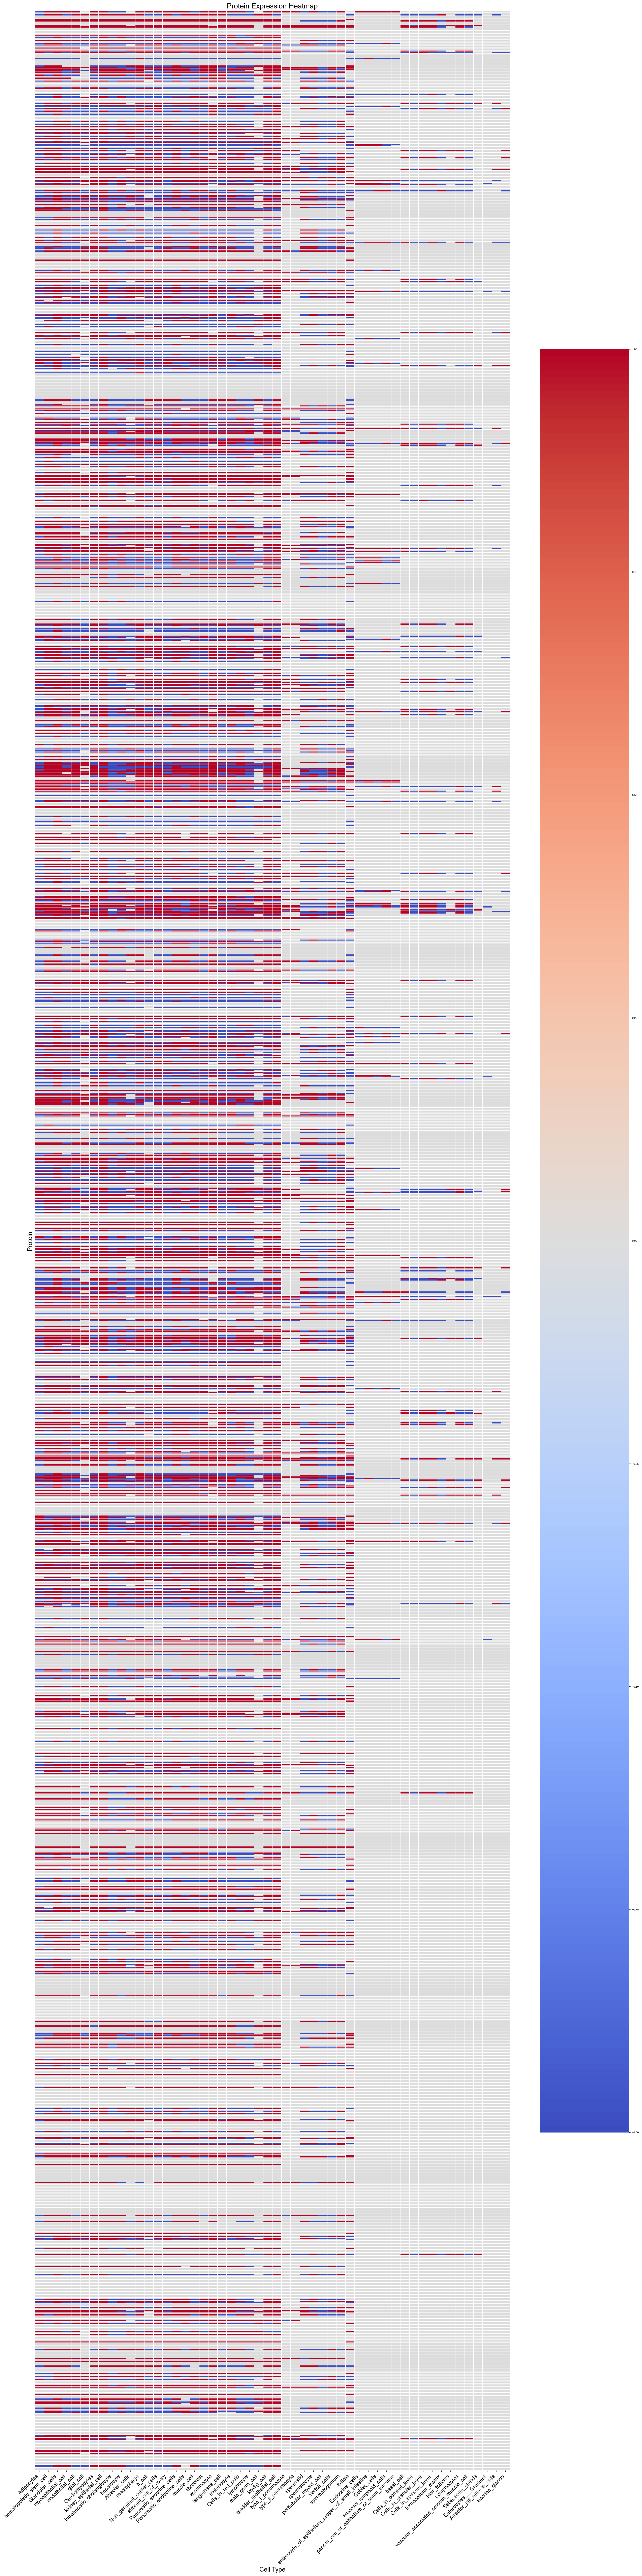

In [126]:
# Define figure size (width x height) to fit large number of genes
plt.figure(figsize=(20, 80))  # Increase height to fit all genes

# Create heatmap
ax = sns.heatmap(test, cmap="coolwarm", linewidths=0.2, annot=False, cbar=True)

# Adjust tick labels
plt.xticks(rotation=45, ha="right", fontsize=12)  # Rotate x-axis labels for better readability
plt.yticks([])  # Remove y-axis labels since 1635 genes are too many to display

# Set labels and title
plt.xlabel("Cell Type", fontsize=14)
plt.ylabel("Protein", fontsize=14)
plt.title("Protein Expression Heatmap", fontsize=16)

# Adjust layout to prevent cutoff
plt.tight_layout()

# Show the heatmap
plt.show()

In [127]:
TFproDet.Standard_CT_names.unique()

array(['Adipocytes', 'hematopoietic_stem_cell', 'Glandular_cells',
       'myoepithelial_cell', 'endothelial_cell', 'glial_cell',
       'Cardiomyocytes', 'kidney_epithelial_cell',
       'intrahepatic_cholangiocyte', 'hepatocyte', 'Alveolar_cells',
       'macrophage', 'b_cell', 'Non_germinal_center_cells',
       'stromal_cell_of_ovary', 'Pancreatic_exocrine_cells',
       'Pancreatic_endocrine_cells', 'muscle_cell', 'fibroblast',
       'keratinocyte', 'langerhans_cell', 'melanocyte',
       'Cells_in_red_pulp', 'lymphocyte', 'male_germ_cell', 'leydig_cell',
       'bladder_urothelial_cell', 'type_i_pneumocyte',
       'type_ii_pneumocyte', 'spermatid', 'spermatocyte',
       'peritubular_myoid_cell', 'Sertoli_cells', 'spermatogonium',
       'follicle', 'Endocrine_cells',
       'enterocyte_of_epithelium_proper_of_small_intestine',
       'Goblet_cells', 'Mucosal_lymphoid_cells',
       'paneth_cell_of_epithelium_of_small_intestine', 'basal_cell',
       'Cells_in_corneal_layer', '

In [128]:

#set(meanexpCT.index).intersection(set(TFproDet.Standard_CT_names.unique()))

xlist = list(set(TFproDet.Standard_CT_names.unique()) - set(meanexpCT.index))
#xlist = ['nan', 'lymphocyte', 'follicle']
TFproDet[TFproDet.Standard_CT_names.isin(xlist)]



,ensembl_id,antibody_id,tissue,cell_type,staining,intensity,quantity,location,reliability_score,Standardized_Tissue,Standard_CT_names
gene_name,,,,,,,,,,,
NFYA,ENSG00000001167,CAB009250,Adipose tissue,Adipocytes,1.0,weak,>75%,cytoplasmic/membranous,enhanced,Fat,Adipocytes
NFYA,ENSG00000001167,CAB009250,Breast,Adipocytes,1.0,weak,>75%,cytoplasmic/membranous,enhanced,Mammary,Adipocytes
NFYA,ENSG00000001167,CAB009250,Breast,Glandular cells,1.0,weak,>75%,cytoplasmic/membranous,enhanced,Mammary,Glandular_cells
NFYA,ENSG00000001167,CAB009250,Colon,Glandular cells,2.0,moderate,>75%,cytoplasmic/membranous,enhanced,Large_Intestine,Glandular_cells
NFYA,ENSG00000001167,CAB009250,Lymph node,Non-germinal center cells,3.0,strong,>75%,nuclear,enhanced,Lymph_Node,Non_germinal_center_cells
...,...,...,...,...,...,...,...,...,...,...,...
HOMEZ,ENSG00000290292,HPA036317,Spleen,Cells in red pulp,0.0,negative,none,none,enhanced,Spleen,Cells_in_red_pulp
HOMEZ,ENSG00000290292,HPA036317,Spleen,Cells in white pulp,0.0,negative,none,none,enhanced,Spleen,lymphocyte
HOMEZ,ENSG00000290292,HPA036317,Stomach 1,Glandular cells,0.0,weak,<25%,nuclear,enhanced,Stomach,Glandular_cells


In [129]:
testtested = test.loc[ TFproDet.index.unique() , test.columns[test.columns.isin(meanexpCT.index)] ]
testtested.shape

(699, 32)

In [130]:
# Define figure size (width x height) to fit large number of genes
plt.figure(figsize=(25, 80))  # Increase height to fit all genes

# Create heatmap
ax = sns.heatmap(testtested, cmap="coolwarm", linewidths=0.2, annot=False, cbar=True)

# Adjust tick labels
plt.xticks(rotation=45, ha="right", fontsize=12)  # Rotate x-axis labels for better readability
plt.yticks([])  # Remove y-axis labels since 1635 genes are too many to display

# Set labels and title
plt.xlabel("Tissue", fontsize=14)
plt.ylabel("Protein", fontsize=14)
plt.title("Protein Expression Heatmap", fontsize=16)

# Adjust layout to prevent cutoff
plt.tight_layout()

# Show the heatmap
plt.show()

In [131]:
def plot_ct_histo(dat, size, titl, fname):
    plt.figure(figsize = size)
    dat[dat != 1] = 0
  
    bins = [x - 0.5 for x in range(1, 33)]  # 0..33 as the centers
    display(dat.T.sum().value_counts())
    plt.hist(dat.T.sum(), bins=bins, linewidth = 0.5, width=0.9)
    
    plt.xlabel('Number of cell types where TF was detected in Protein Atlas')
    plt.ylabel("Number of TFs detected")
    plt.title(titl)
    plt.xticks(range(33))
    plt.tight_layout()

    plt.savefig(DATA_IN_DIR + fname)
    plt.show()
    return()

(699, 32)


22    62
21    59
19    37
17    37
20    35
23    33
25    29
4     26
26    26
18    25
13    25
15    25
7     24
11    22
1     21
6     21
14    21
24    21
9     19
16    16
8     16
2     16
5     15
3     15
12    14
0     11
27    11
10     9
28     6
29     1
30     1
Name: count, dtype: int64

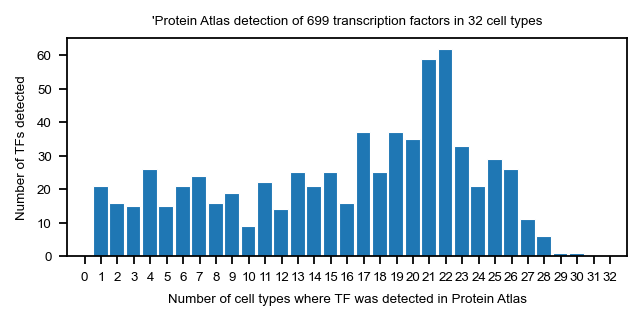

()

In [132]:
print(testtested.shape)

titlestring = "'Protein Atlas detection of " + str(len(testtested.index)) + " transcription factors in " + str(len(testtested.columns)) + " cell types"
plot_ct_histo(testtested.copy(), (4.0, 2.0), titlestring, 'SuppFig_CT_all_TF_panelX.pdf')

In [133]:
vcnts = testtested.melt().value_counts('value')
display(vcnts)
fracValidated = vcnts[1] / (vcnts[1] + vcnts[-1])
print('The overall fraction of TFs detected in protein atlas is', fracValidated)

value
 1    10893
-1     6027
 0     5448
Name: count, dtype: int64

The overall fraction of TFs detected in protein atlas is 0.6437943262411348


In [134]:
def plotcthistopPCT(dat,size, titl, fname):
    plt.figure(figsize = size)
    det = dat.copy().T
    ndet = dat.copy().T
    det[det != 1] = 0
    ndet[ndet != -1] = 0
    ndet[ndet == -1] = 1
    datpct = det.sum() / (det.sum() + ndet.sum())
    display(datpct.sort_values(ascending = False))
    
    plt.hist(datpct.sort_values(), bins = 20, linewidth = 0.5)
    plt.xlabel('Fraction of cell types where TF was detected in Protein Atlas')
    plt.ylabel("Number of TFs detected")
    plt.title(titl)
    plt.xlim(left=0)
    plt.tight_layout()
    plt.savefig(DATA_IN_DIR + fname)    
    plt.show()
    return(datpct)


In [135]:
testtested[testtested.index == 'SON']

,hematopoietic_stem_cell,myoepithelial_cell,endothelial_cell,glial_cell,Cardiomyocytes,kidney_epithelial_cell,intrahepatic_cholangiocyte,hepatocyte,Alveolar_cells,macrophage,...,type_i_pneumocyte,type_ii_pneumocyte,spermatid,spermatocyte,peritubular_myoid_cell,spermatogonium,enterocyte_of_epithelium_proper_of_small_intestine,paneth_cell_of_epithelium_of_small_intestine,basal_cell,vascular_associated_smooth_muscle_cell
gene_name,,,,,,,,,,,,,,,,,,,,,
SON,1,1,1,0,1,1,-1,1,0,1,...,1,1,1,1,-1,1,0,0,1,1


gene_name
E2F1      1.0
ZNF22     1.0
GLI2      1.0
ZBTB2     1.0
POU6F1    1.0
         ... 
FEZF1     0.0
OTP       0.0
NRL       0.0
BARX2     0.0
ZMAT1     0.0
Length: 699, dtype: float64

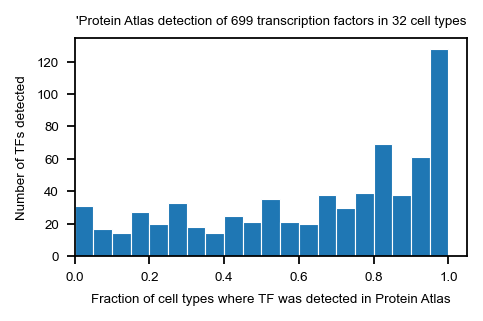

Fraction of TF found positive in all cell types tested  0.11158798283261803
Fraction of TF found positive in > 0.80 of cell types tested 0.40486409155937053


In [136]:
# Tricky, but if TF was tested in 2 celltypes only and positive in one but not the other, it is 0.5 in this chart.
# Many of these were tested in 20-23 cell types and found in all of those cell types.

titlestring = "'Protein Atlas detection of " + str(len(testtested.index)) + " transcription factors in " + str(len(testtested.columns)) + " cell types"
x = plotcthistopPCT(testtested.copy(), (3.0, 2.0), titlestring, 'SuppFig5D_CT_proall_tau_TF.pdf')
print('Fraction of TF found positive in all cell types tested ', len(x[x==1.0]) / len(x))
print('Fraction of TF found positive in > 0.80 of cell types tested', len(x[x>0.80]) / len(x))

## 100 Lowest Tau Plots

In [137]:
lowTaus = TFtaus.tail(100)
testlow = testtested[testtested.index.isin(lowTaus.index)].sort_values('gene_name')
display(testlow)
#list(testlow.index)

,hematopoietic_stem_cell,myoepithelial_cell,endothelial_cell,glial_cell,Cardiomyocytes,kidney_epithelial_cell,intrahepatic_cholangiocyte,hepatocyte,Alveolar_cells,macrophage,...,type_i_pneumocyte,type_ii_pneumocyte,spermatid,spermatocyte,peritubular_myoid_cell,spermatogonium,enterocyte_of_epithelium_proper_of_small_intestine,paneth_cell_of_epithelium_of_small_intestine,basal_cell,vascular_associated_smooth_muscle_cell
gene_name,,,,,,,,,,,,,,,,,,,,,
ADNP,1,1,1,0,1,1,-1,-1,0,1,...,1,1,-1,1,-1,1,1,1,0,0
AKAP8L,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,0,0,1,-1
ARNT,1,1,1,1,-1,1,-1,-1,1,1,...,1,1,-1,-1,-1,1,0,0,1,1
ASH1L,1,0,0,0,-1,-1,-1,-1,1,1,...,0,0,0,0,0,0,0,0,0,0
ATF1,1,1,1,1,1,1,1,-1,-1,1,...,1,1,1,1,-1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZNF263,1,1,1,0,1,1,-1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
ZNF37A,0,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
ZNF384,1,1,1,0,1,1,1,-1,0,1,...,1,1,-1,-1,1,-1,0,0,0,0


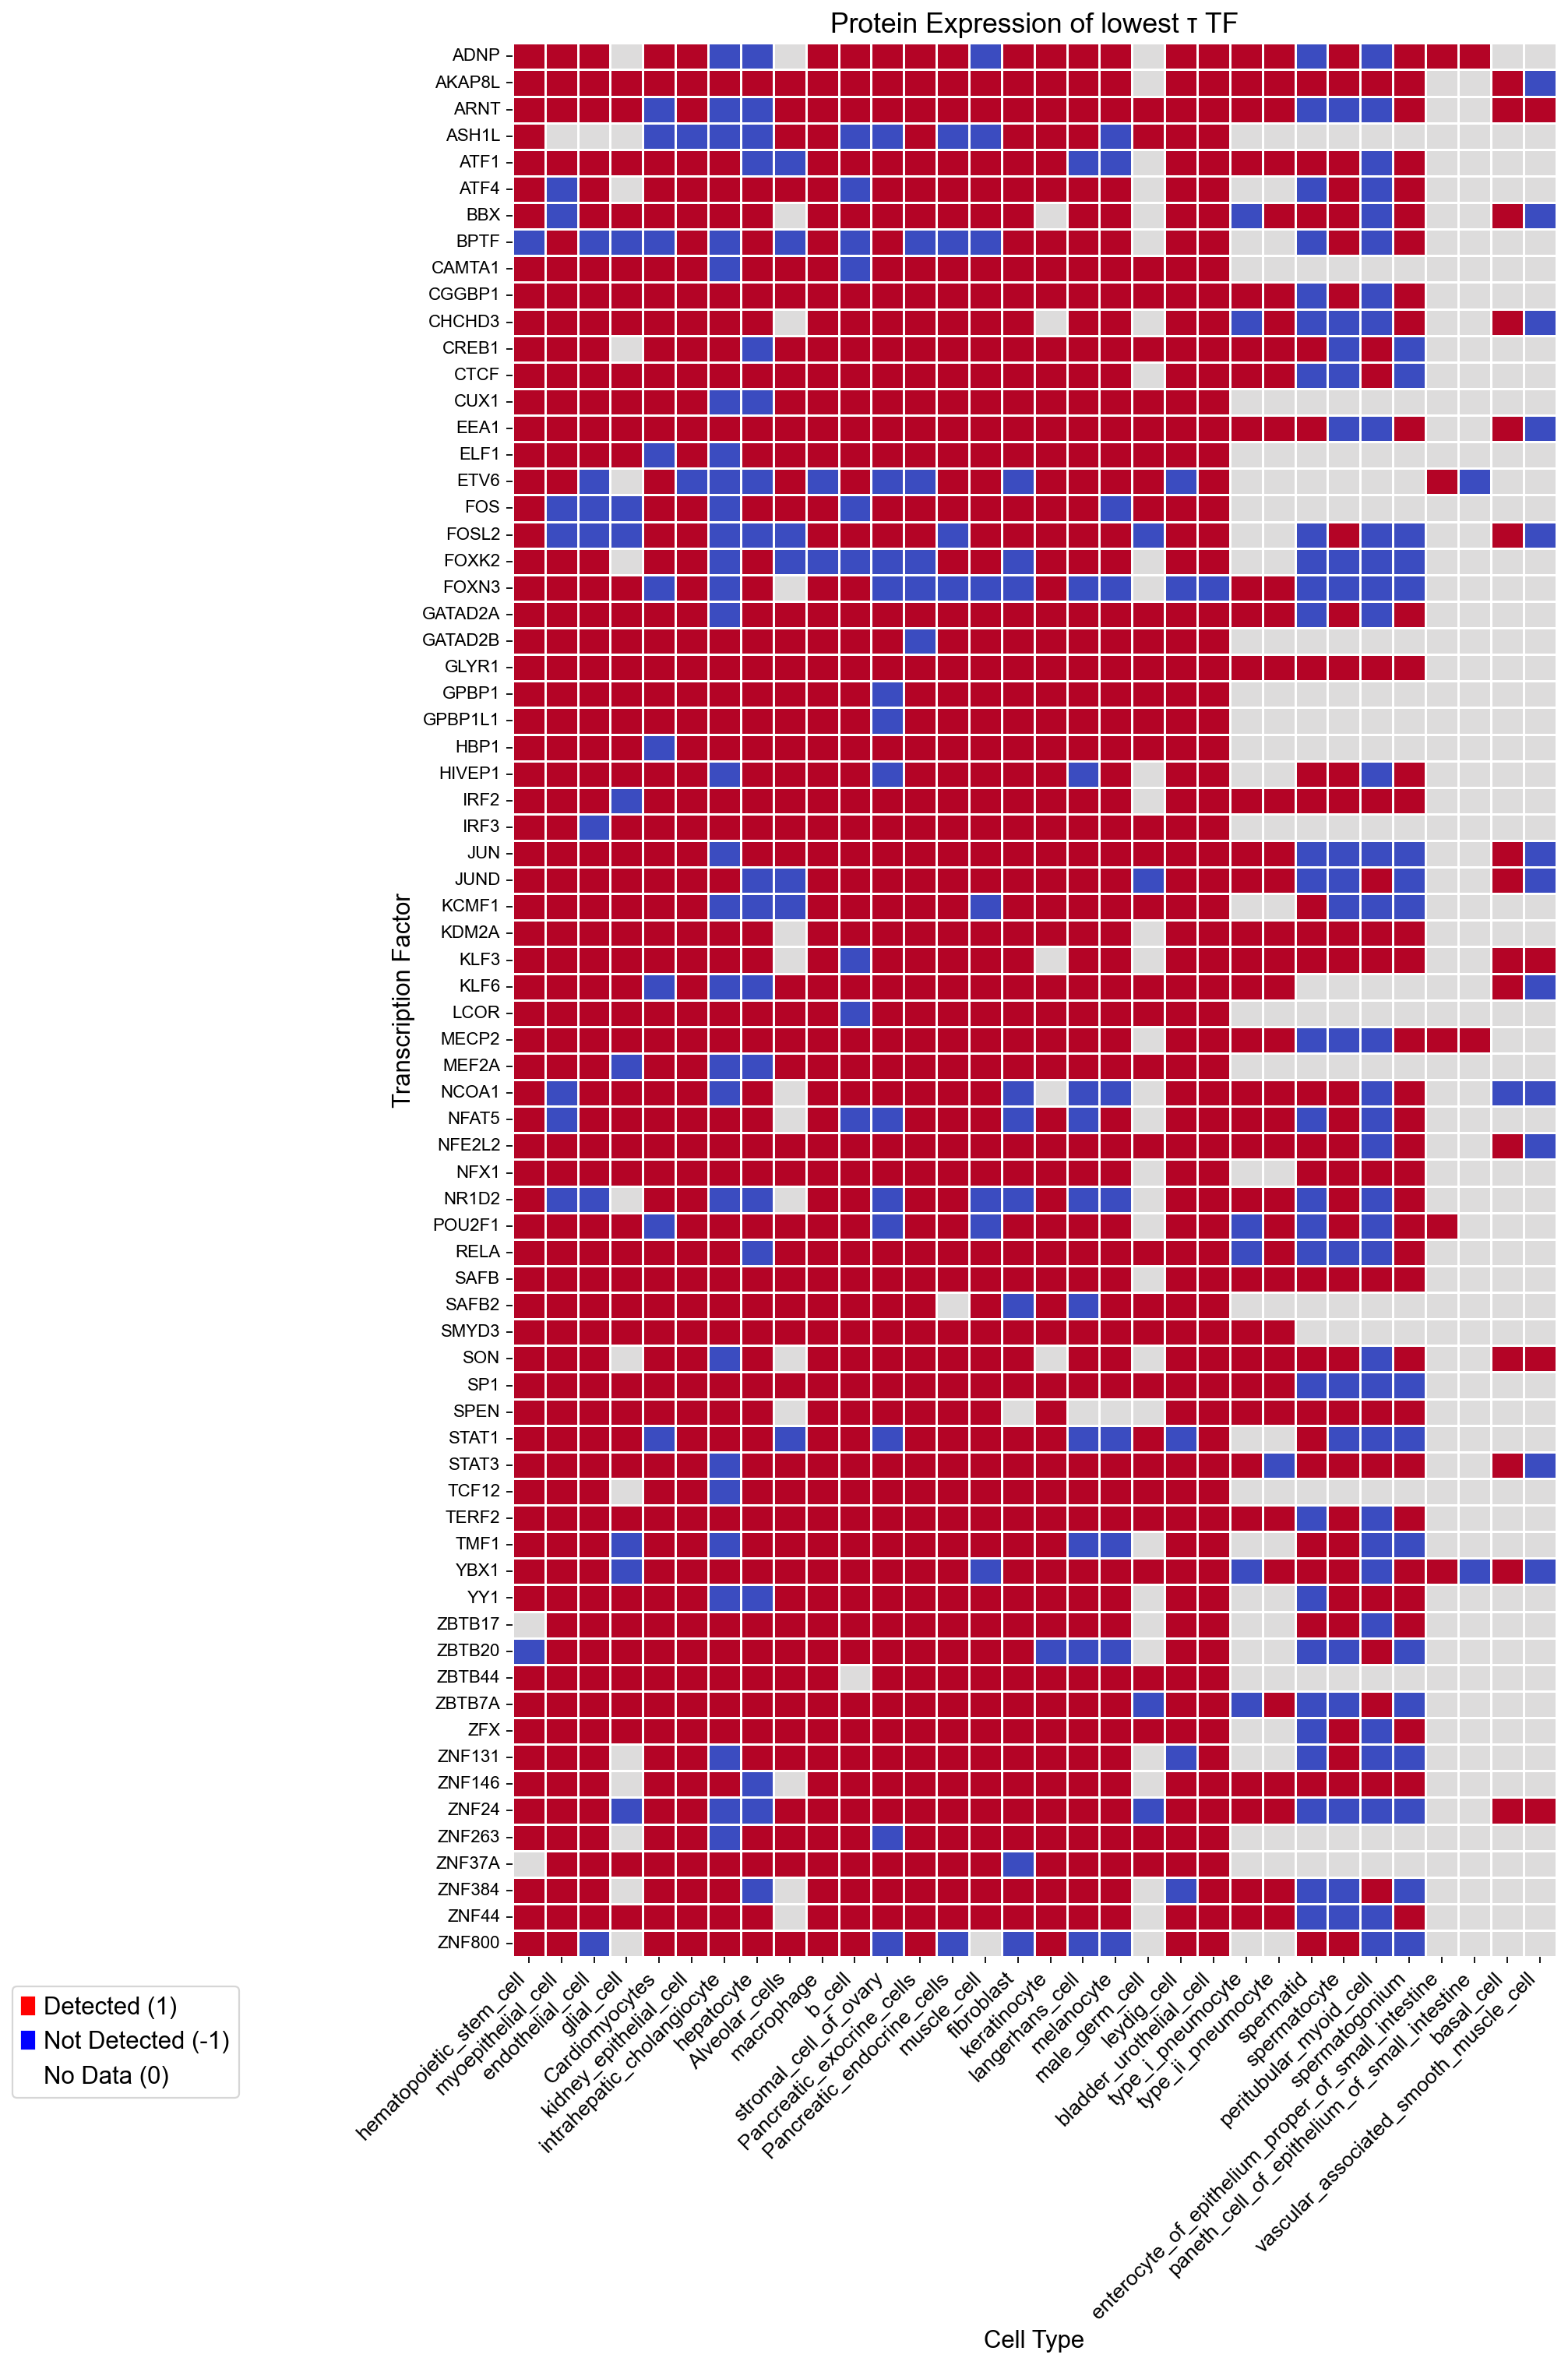

In [138]:

plt.figure(figsize=(13, 19))

# Create the heatmap without color bar
ax = sns.heatmap(testlow, 
                 cmap="coolwarm", 
                 linewidths=0.5, 
                 annot=False, 
                 cbar=False)  # Remove color bar

# remove X axis labels
#ax.set_xticks([])
#ax.set_xticklabels([])

# Improve axis labels
plt.xticks(rotation=45, ha="right", fontsize=12)  # Rotate tissue labels
plt.yticks(fontsize=10)  # Adjust y-axis font size

# Set title and labels
plt.title("Protein Expression of lowest τ TF", fontsize=16)
plt.ylabel("Transcription Factor", fontsize=14)
plt.xlabel("Cell Type", fontsize=14)

# Create a custom legend for the three states
legend_patches = [
    mpatches.Patch(color="red", label="Detected (1)"),
    mpatches.Patch(color="blue", label="Not Detected (-1)"),
    mpatches.Patch(color="white", label="No Data (0)")
]

# Add the legend to the plot
plt.legend(handles=legend_patches, bbox_to_anchor=(-0.25, -0.08),  loc='lower right', fontsize=14)

# Adjust layout to prevent cutoff
plt.tight_layout()
plt.savefig(DATA_IN_DIR + 'SuppFig_CT_Low_Tau_HMap_panelE.pdf')
plt.show()

(72, 32)


24    9
19    8
21    8
22    7
20    7
23    7
26    7
13    3
27    3
28    3
25    2
16    2
11    1
10    1
14    1
17    1
18    1
15    1
Name: count, dtype: int64

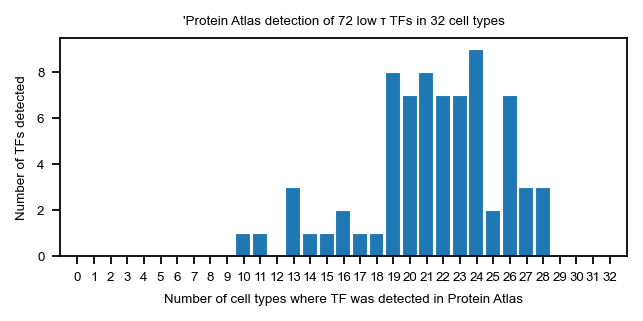

In [139]:
print(testlow.shape)
titlestring = "'Protein Atlas detection of " + str(len(testlow.index)) + " low τ TFs in " + str(len(testlow.columns)) + " cell types"
plot_ct_histo(testlow.copy(), (4.0, 2.0), titlestring, 'SuppFig_CT_low_tau_panelX.pdf');

(72, 32)


gene_name
GLYR1     1.000000
KDM2A     1.000000
SAFB      1.000000
ZBTB44    1.000000
SPEN      1.000000
            ...   
NR1D2     0.560000
FOXK2     0.541667
ASH1L     0.526316
BPTF      0.520000
FOXN3     0.423077
Length: 72, dtype: float64

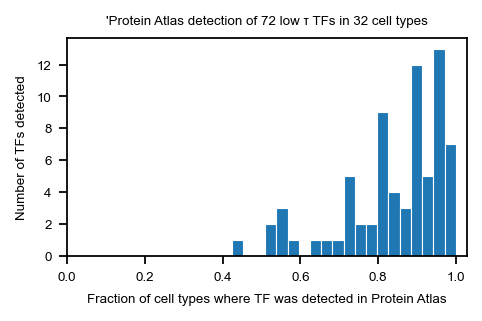

Number of TF found in > 0.80 of cell types: 0.6944444444444444


In [140]:
print(testlow.shape)
x = plotcthistopPCT(testlow.copy(), (3.0, 2.0), titlestring, 'SuppFig5C_CT_prolow_tau.pdf')
print('Number of TF found in > 0.80 of cell types:', len(x[x>0.80]) / len(x))

In [141]:
# check with text list
examples = ['NFAT5', 'NCOA1', 'FOXJ3', 'FOXK2', 'ATF4', 'JUN', 'FOS', 'STAT1']
lowTaus.loc[examples, : ]
# yes, they are all ubiquitous ie. in the lowest 100 tau...

,tau
NFAT5,0.483908
NCOA1,0.505063
FOXJ3,0.532092
FOXK2,0.549485
ATF4,0.567635
JUN,0.576106
FOS,0.615999
STAT1,0.616440


## 100 Highest Tau Plots

In [142]:
hiTaus = TFtaus.head(100)
hiTaus

,tau
FOXD4L4,0.999868
FIGLA,0.999667
GSX2,0.999634
NEUROG1,0.999582
HOXC12,0.999473
...,...
GBX2,0.992344
ZSCAN5B,0.992327
HOXD9,0.992311
VSX2,0.992226


In [143]:
hiTaus = TFtaus.head(100)
testhi = testtested[testtested.index.isin(hiTaus.index)].sort_values('gene_name')
testhi.shape

(22, 32)

In [144]:
testhi

,hematopoietic_stem_cell,myoepithelial_cell,endothelial_cell,glial_cell,Cardiomyocytes,kidney_epithelial_cell,intrahepatic_cholangiocyte,hepatocyte,Alveolar_cells,macrophage,...,type_i_pneumocyte,type_ii_pneumocyte,spermatid,spermatocyte,peritubular_myoid_cell,spermatogonium,enterocyte_of_epithelium_proper_of_small_intestine,paneth_cell_of_epithelium_of_small_intestine,basal_cell,vascular_associated_smooth_muscle_cell
gene_name,,,,,,,,,,,,,,,,,,,,,
ASCL1,-1,-1,-1,0,-1,-1,-1,-1,-1,1,...,0,0,0,0,0,0,1,-1,0,0
CTCFL,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,0,0,1,1,-1,1,0,0,0,0
EMX1,0,1,1,-1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
ESX1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,0,0,1,1,-1,1,0,0,0,0
FAM170A,-1,-1,-1,-1,-1,1,-1,-1,-1,1,...,0,0,1,1,-1,1,0,0,0,0
FIGLA,-1,-1,0,-1,-1,-1,-1,-1,-1,-1,...,0,0,0,0,0,0,0,0,0,0
FOXB2,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,...,0,0,0,0,0,0,0,0,0,0
FOXI1,1,1,-1,-1,-1,1,-1,-1,-1,-1,...,0,0,0,0,0,0,0,0,0,0
FOXP3,-1,-1,-1,-1,-1,-1,-1,-1,0,1,...,-1,-1,0,0,0,0,0,0,0,0


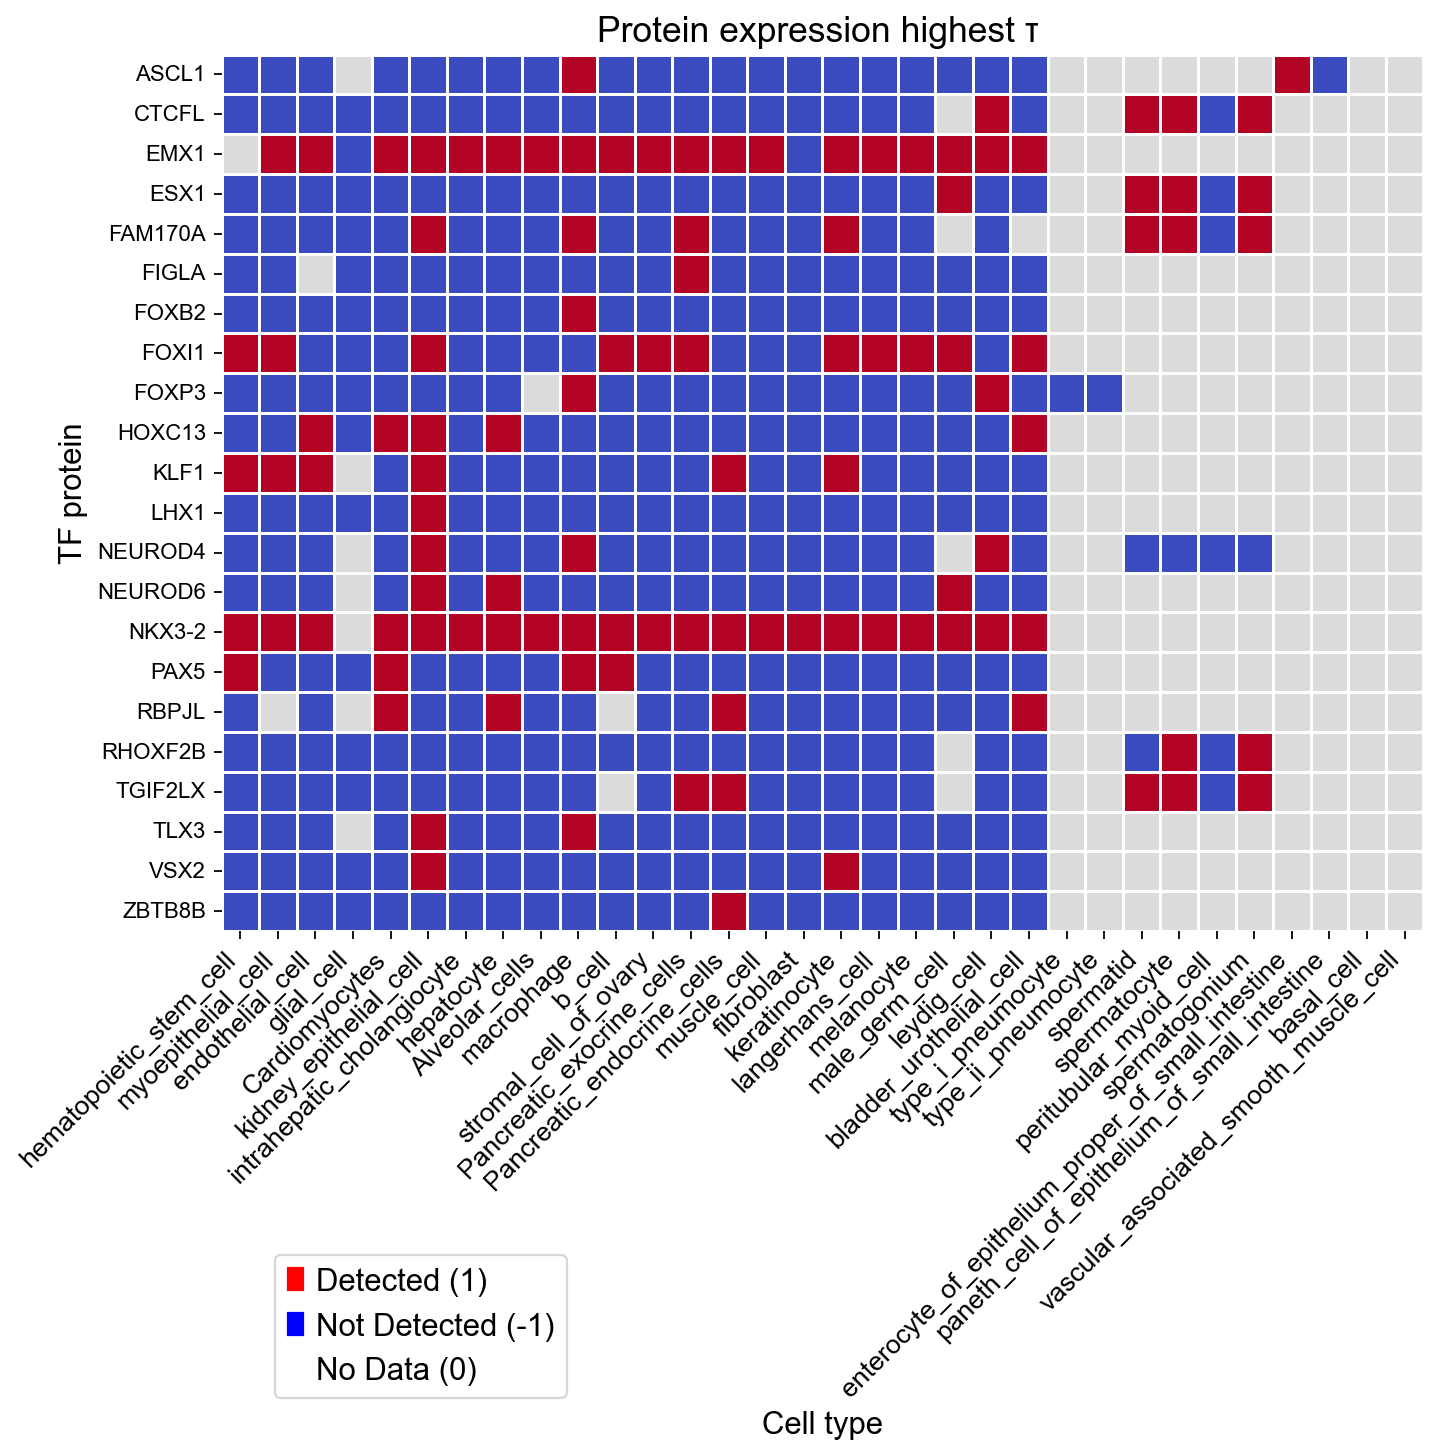

In [145]:
# Set figure size
plt.figure(figsize=(9,10))

# Create the heatmap without color bar
ax = sns.heatmap(testhi, 
                 cmap="coolwarm", 
                 linewidths=0.5, 
                 annot=False, 
                 cbar=False)  # Remove color bar

# Improve axis labels
plt.xticks(rotation=45, ha="right", fontsize=12)  # Rotate tissue labels
plt.yticks(fontsize=10)  # Adjust y-axis font size

# Set title and labels
plt.title("Protein expression highest τ ", fontsize=16)
plt.ylabel("TF protein", fontsize=14)
plt.xlabel("Cell type", fontsize=14)

# Create a custom legend for the three states
legend_patches = [
    mpatches.Patch(color="red", label="Detected (1)"),
    mpatches.Patch(color="blue", label="Not Detected (-1)"),
    mpatches.Patch(color="white", label="No Data (0)")
]

plt.legend(handles=legend_patches, bbox_to_anchor=(0.30, -0.55),  loc='lower right', fontsize=14)

# Adjust layout to prevent cutoff
plt.tight_layout()
plt.savefig(DATA_IN_DIR + 'SuppFig_CT_Hi_Tau_HMap_panelX.pdf')
plt.show()

gene_name
NKX3-2     1.000000
EMX1       0.904762
FOXI1      0.500000
FAM170A    0.291667
KLF1       0.285714
HOXC13     0.227273
RBPJL      0.210526
TGIF2LX    0.208333
PAX5       0.181818
CTCFL      0.160000
ESX1       0.153846
NEUROD6    0.142857
NEUROD4    0.125000
TLX3       0.095238
VSX2       0.090909
FOXP3      0.086957
ASCL1      0.086957
RHOXF2B    0.080000
FIGLA      0.047619
LHX1       0.045455
FOXB2      0.045455
ZBTB8B     0.045455
dtype: float64

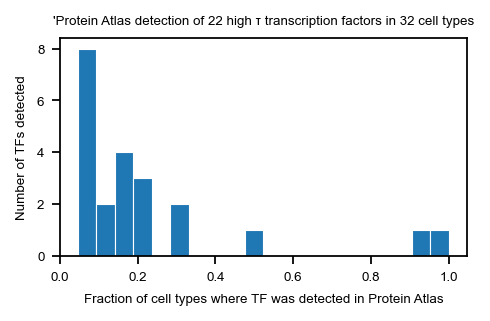

Number of TF found in > 0.80 of cell types: 0.09090909090909091


In [146]:
titlestring = "'Protein Atlas detection of " + str(len(testhi.index)) + " high τ transcription factors in " + str(len(testlow.columns)) + " cell types"
x = plotcthistopPCT(testhi.copy(), (3.0, 2.0), titlestring, 'SuppFig_CT_Hi_Tau_panelX.pdf' )
print('Number of TF found in > 0.80 of cell types:', len(x[x>0.80]) / len(x))

## 100 uncharacterized TF's Plots

In [147]:
# this analysis was for reviewer reply so not pushed to github

## Find fraction of TF-Celltype positive combinations from RNA that are confirmed positive in Protein Atlas

In [148]:
# this analysis was for reviewer reply so not pushed to github